## Librerias usadas

In [ ]:
import cvxpy as cp
from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import numpy as np
import matplotlib.pyplot as plt
import random

import cv2
from PIL import Image
from IPython.display import display, clear_output

## 1.Distancias entre conjuntos convexos

### 1.1. Definiciones de distancias

In [ ]:
def disteuclid(n,A1,A2):  
    s=0
    for i in range(n):
        s=s+(A1[i]-A2[i])**2
    d=np.sqrt(s)
    return(d)

In [ ]:
def Squaredistance2(A1,A2):
    return (A1[0]-A2[0])**2+(A1[1]-A2[1])**2

In [ ]:
def norma_ptop(x,p,dim):
    return np.ones(dim) @ cp.abs(x)**p

In [ ]:
def tnorma_ptop(x,p,dim):
  return np.ones(dim) @ x**p

###1.2. Distancia entre dos conjuntos

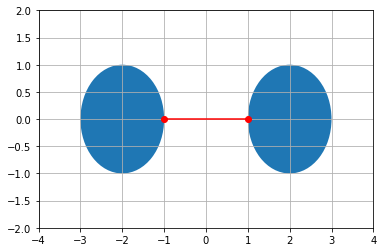

In [ ]:
##1.2.1

fig, ax = plt.subplots()
ax.set(xlim=(-4, 4), ylim = (-2,2))
plt.plot([-1,1],[0,0], '-o',color='red')

a_circle = plt.Circle((-2, 0), 1)
b_circle = plt.Circle((2, 0), 1)
ax.add_artist(a_circle)
ax.add_artist(b_circle)
#plt.xticks(range(-4,4)) 
#plt.yticks(range(-2,2)) 
plt.grid()


In [ ]:
##1.2.2

x = cp.Variable(shape=(2,1), name="x")
y = cp.Variable(shape=(2,1), name="y")

prob = cp.Problem(cp.Minimize(Squaredistance2(x,y)),
                  [Squaredistance2(x,[-2,0])<=1,Squaredistance2(y,[2,0])<=1])
prob.solve()

print("\nThe optimal value for the square distance2  is: \n",prob.value,"  ")
print("\nThe optimal value for the distance2  is: \n",np.sqrt(prob.value)," ")


print("\nA solution x,y is")
print([float(x.value[0]),float(x.value[1])],",",[float(y.value[0]),float(y.value[1])])
print(" ")


The optimal value for the square distance2  is: 
 3.999999948794555   

The optimal value for the distance2  is: 
 1.9999999871986387  

A solution x,y is
[-0.9999999970719713, 0.0] , [0.9999999970719429, 0.0]
 


##2. Clausura convexa de una cantidad finita de puntos

En el siguiente código nos enfocamos a entender el funcionamiento básico de la líbería scipy.spatial 

In [ ]:
points = np.random.rand(10, 2)   # 30 random points in 2-D
hull = ConvexHull(points)

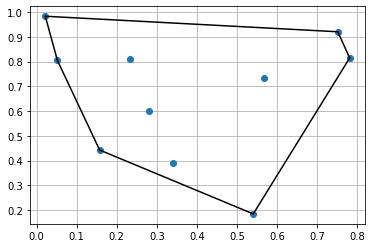

In [ ]:
#2.1.

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0],points[simplex, 1],  'k-')
plt.grid()

In [ ]:
points[hull.vertices]

array([[0.54079753, 0.1844813 ],
       [0.78156338, 0.81441949],
       [0.75198871, 0.92027318],
       [0.0213908 , 0.982989  ],
       [0.05170527, 0.80438017],
       [0.15711994, 0.44259163]])

In [ ]:
points[hull.vertices][:,0]

array([0.54079753, 0.78156338, 0.75198871, 0.0213908 , 0.05170527,
       0.15711994])

In [ ]:
hull.vertices

array([9, 0, 7, 2, 3, 8], dtype=int32)

El orden de los vértices se describe en contra de las manecillas del reloj. Esta observación es útil para el planteamiento de restricciones que describen estos politopos.

## 3. Clausura convexa del contorno de imagenes

En este caso nos vamos a enfocar en la clausura convexa del casco urbano de la ciudad de Bogotá.

In [ ]:
image = cv2.imread("bogota croquis.jpg", 1)

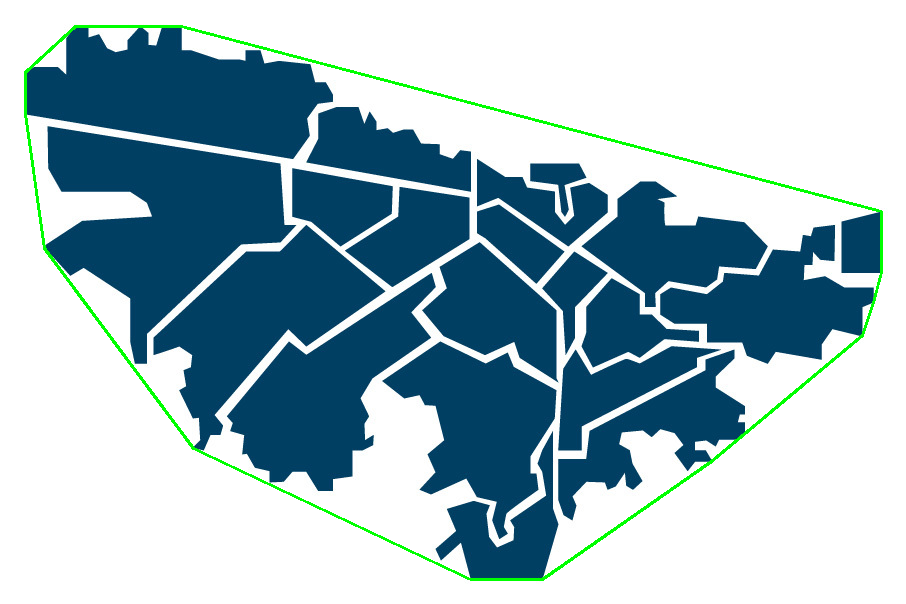

In [ ]:
##3.1.

original_image= image

gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
edges= cv2.Canny(gray, 50,200)

contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# por localidades es sufiente considerar cnt=contours[0]

cnt=np.concatenate(contours)
hull= cv2.convexHull(cnt)

cv2.drawContours(image, [hull],0,(0,255,0),2)
#cv2.imshow('Convex Hull', image)

croquis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(croquis)) 

cv2.destroyAllWindows()

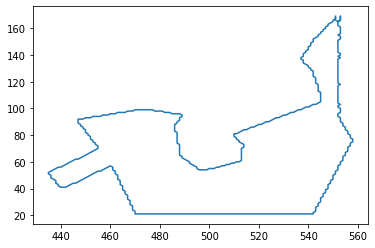

In [ ]:
plt.plot(contours[0][:,:,0],600-contours[0][:,:,1])

##4. Plantemiento de las desigualdades que generan un conjunto convexo

In [ ]:
##4.1.

a=[np.flip(hull[:,:,0]),600-np.flip(hull[:,:,1])]

l=len(hull[:,:,0])

M=np.zeros((l,2))
b=np.zeros(l)

for i in range(l-1):
    M[i,0]=a[1][i+1]-a[1][i]
    M[i,1]=-(a[0][i+1]-a[0][i])
    b[i]=M[i,0]*a[0][i] + M[i,1]*a[1][i]

M[l-1,0]=  a[1][0]-a[1][l-1]
M[l-1,1]= -(a[0][0]-a[0][l-1])
b[l-1]= M[l-1,0]*a[0][l-1] + M[l-1,1]*a[1][l-1]

In [ ]:
x = cp.Variable(shape=(2,1), name="x")


constraints = [M[i]@x<=b[i] for i in range(len(b))]

prob = cp.Problem(cp.Minimize(cp.pnorm([[600,500]]-x,2)+cp.pnorm(x-[[3,1]],2)), constraints )
prob.solve()

x.value


array([[361.28186661],
       [300.47971844]])

#5. Generalización del problema de Herón 

In [ ]:
##5.1

x = cp.Variable(shape=(2,1), name="x")
prob = cp.Problem(cp.Minimize(cp.pnorm([[-1,2]]-x,2)+cp.pnorm(x-[[3,1]],2)),[[[-1,-1]]<= x,x <= [[1,1]]])
prob.solve()


# Print result.
print("\nThe optimal value is")
print(prob.value)
print(" ")

print("A solution x is")
print(x.value)
print(" ")


The optimal value is
4.2360679772463765
 
A solution x is
[[1.]
 [1.]]
 


#6. Función Generalización de problema de Herón

In [ ]:
##6.1.

def MinConv(X,points,p,pesos,opcion):
    hull = X
    
    #Planteamiento de desigualdades
    
    a=[np.flip(hull[:,:,0]),600-np.flip(hull[:,:,1])]
    #a=[points[hull.vertices][:,0],points[hull.vertices][:,1]]

    l=len(hull[:,:,0])

    M=np.zeros((l,2))
    b=np.zeros(l)

    for i in range(l-1):
        M[i,0]=a[1][i+1]-a[1][i]
        M[i,1]=-(a[0][i+1]-a[0][i])
        b[i]=M[i,0]*a[0][i] + M[i,1]*a[1][i]

    M[l-1,0]=  a[1][0]-a[1][l-1]
    M[l-1,1]= -(a[0][0]-a[0][l-1])
    b[l-1]= M[l-1,0]*a[0][l-1] + M[l-1,1]*a[1][l-1]
    
    #Restricciones y funcion objetivo
    
    constraints = [M[i]@x<=b[i] for i in range(len(b))]
    suma=0
    j=0
    for i in points:
        suma=suma+cp.pnorm([i]-x,p)*pesos[j]
        j+=1
    
    objetive=cp.Minimize(suma)
    
    #Solución al problema de optimización
    
    prob = cp.Problem(objetive , constraints )
    prob.solve()
    
    if opcion!=0:
        print("\nThe optimal value is")
        print(prob.value)
        print("A solution x is")
        print(x.value)
        print(" ")
    return x.value

In [ ]:
##6.2.

points=[[600,500],[3,1]]
pesos=[1,1]
h=MinConv(hull,points,2,pesos,1);


The optimal value is
778.080973030158
A solution x is
[[361.28186661]
 [300.47971844]]
 


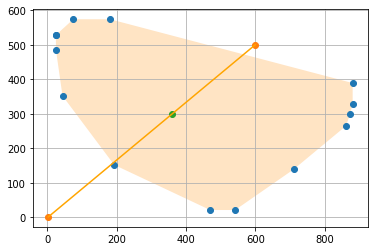

In [ ]:
##6.3.

plt.fill(hull[:,:,0],600-hull[:,:,1],'bisque')
plt.plot(hull[:,:,0],600-hull[:,:,1], 'o')

plt.plot([600,3],[500,1],'o')
plt.plot([361.28186661],
       [300.47971844],'o')

plt.plot([600,361.28186661,3],[500,300.47971844,1],'orange')
plt.grid()

In [ ]:
##6.4.

points2=[[600,500],[3,1],[600,200]]
pesos2=np.ones(3)
h2=MinConv(hull,points2,2,pesos2,0);


The optimal value is
925.1596077308116
A solution x is
[[562.69168372]
 [228.97888433]]
 


##7. Visualización de los puntos



In [ ]:
##7.1

def mapa(P,points):
  pointss=np.array(points)

  plt.fill(hull[:,:,0],600-hull[:,:,1],'bisque')

  for p in points:
    plt.plot([p[0],P[0,0]],[p[1],P[1,0]],'orange','o')

  plt.plot([P[0,0]],[P[1,0]],'o')
  plt.plot(pointss[:,0],pointss[:,1], 'o')
  plt.grid()

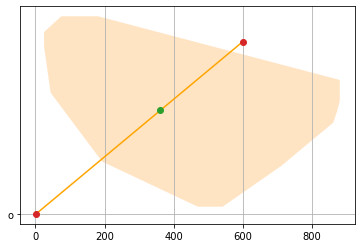

In [ ]:
mapa(h,points)

In [ ]:
##7.2

r=MinConv(hull,points2,2,pesos2,1)
u=MinConv(hull,points2,'inf',pesos2,1)


The optimal value is
925.1596077308116
A solution x is
[[562.69168372]
 [228.97888433]]
 

The optimal value is
747.000000284612
A solution x is
[[449.99999993]
 [349.99999992]]
 


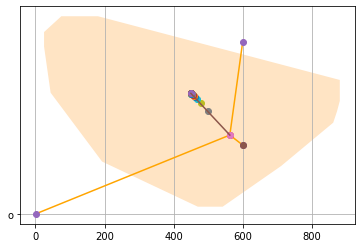

In [ ]:
##7.3

mapa(h2,points2)
for i in range(1,100):
  z=MinConv(hull,points2,i,pesos2,0)
  plt.plot(z[0],z[1],'o')

z=MinConv(hull,points2,'inf',pesos2,0)
plt.plot(z[0],z[1],'o')


plt.plot([r[0,0],u[0,0]],[r[1,0],u[1,0]])


The optimal value is
3048.0116459682054
A solution x is
[[540.09361381]
 [424.18680117]]
 


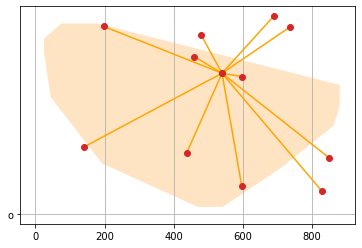

In [ ]:
##7.4

k=random.randint(2,15)
pointsk=[[random.random()*900,random.random()*600] for i in range(k)]
pesosk=np.ones(k)
hk=MinConv(hull,pointsk,2,pesosk,1);
mapa(hk,pointsk)

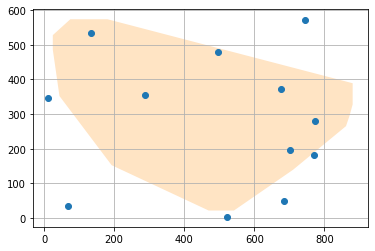

In [ ]:
plt.fill(hull[:,:,0],600-hull[:,:,1],'bisque')

lista=[[135.23068100473182, 533.707943326069],
 [496.1757480180229, 480.43847500380787],
 [774.0197427285553, 280.459114693188],
 [685.7219968543486, 48.05157955658317],
 [289.23671764630535, 355.6154344789127],
 [769.2181039370101, 182.69767440768427],
 [12.092974925423173, 347.6386273456558],
 [675.747086829755, 371.4715284913684],
 [701.0079379019115, 195.1524446872133],
 [68.24184550587164, 33.968381978753335],
 [743.5513800924022, 572.9805970913143],
 [521.6965062509597, 2.54773019048784]]

plt.plot([l[0] for l in lista],[l[1] for l in lista],'o')

plt.grid()

-------------------------------------------
Modificaciones

###8. Clausura convexa de Engativá

In [ ]:
image2 = cv2.imread("bogota croquis.jpg", 1)

original_image2= image2

gray= cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
edges= cv2.Canny(gray, 50,200)

contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# por localidades es sufiente considerar cnt=contours[0]
cnt2=contours[11]
hull2= cv2.convexHull(cnt2)

In [ ]:
## 8.1.

def mapa2(P,points,colour):
  pointss=np.array(points)
  i=0
  for p in points:
    i+=1
    plt.plot([p[0],P[0,0]],[p[1],P[1,0]],colour,'o')
    plt.annotate(f"$p_{i}$", p,textcoords="offset points", # how to position the text
                 xytext=(4,8), # distance from text to points (x,y)
                 ha='left')
  plt.plot([P[0,0]],[P[1,0]],'o')
  plt.plot(pointss[:,0],pointss[:,1], 'o')
  plt.grid()

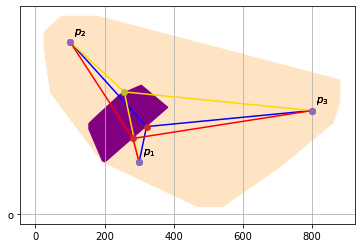

In [ ]:
plt.fill(hull[:,:,0],600-hull[:,:,1],color='bisque')
plt.fill(hull2[:,:,0],600-hull2[:,:,1],'purple')

k=10
#pointsk=[[random.random()*900,random.random()*600] for i in range(k)]
points_1=np.array([[300,150],[100,500],[800,300]])
pesos_1=np.array([0.6,0.1,0.3])
pesos_2=np.ones(3)
pesos_3=np.array([0.1,0.6,0.3])


h_1=MinConv(hull2,points_1,2,pesos_1,0);
h_2=MinConv(hull2,points_1,2,pesos_2,0);
h_3=MinConv(hull2,points_1,2,pesos_3,0);

mapa2(h_2,points_1,'blue')
mapa2(h_3,points_1,'gold')
mapa2(h_1,points_1,'red')
